# Import Libraries

In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


# Data Preproscessing

In [43]:
# Load Data
gold_data = pd.read_csv('data/gold_price_data.csv')
gold_data.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2015-10-01 00:00:00-04:00,1115.199951,1119.000000,1113.300049,1114.199951,1181,0.0,0.0
1,2015-10-02 00:00:00-04:00,1112.199951,1141.199951,1105.800049,1137.099976,323,0.0,0.0
2,2015-10-05 00:00:00-04:00,1137.099976,1141.699951,1132.500000,1138.099976,226,0.0,0.0
3,2015-10-06 00:00:00-04:00,1136.300049,1150.000000,1136.300049,1146.800049,145,0.0,0.0
4,2015-10-07 00:00:00-04:00,1147.599976,1152.900024,1143.000000,1149.000000,104,0.0,0.0


In [44]:
# Preprocess Data
# Create copy of data
preprocessed_data = gold_data.copy()

# drop unnecessary columns
preprocessed_data.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

# Set up tomorrow's close price
preprocessed_data['Tomorrow_Close'] = preprocessed_data['Close'].shift(-1)

# Moving Average
preprocessed_data['MA_2'] = preprocessed_data['Close'].rolling(window=2).mean()
preprocessed_data['MA_7'] = preprocessed_data['Close'].rolling(window=7).mean()
preprocessed_data['MA_30'] = preprocessed_data['Close'].rolling(window=30).mean()
preprocessed_data['MA_90'] = preprocessed_data['Close'].rolling(window=90).mean()
preprocessed_data['MA_365'] = preprocessed_data['Close'].rolling(window=365).mean()

# Trend
preprocessed_data['Trend_2'] = preprocessed_data['Close'].pct_change(periods=2)
preprocessed_data['Trend_7'] = preprocessed_data['Close'].pct_change(periods=7)
preprocessed_data['Trend_30'] = preprocessed_data['Close'].pct_change(periods=30)
preprocessed_data['Trend_90'] = preprocessed_data['Close'].pct_change(periods=90)
preprocessed_data['Trend_365'] = preprocessed_data['Close'].pct_change(periods=365)

#RSI
def compute_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi
preprocessed_data['RSI_14'] = compute_rsi(preprocessed_data, window=14)
preprocessed_data['RSI_30'] = compute_rsi(preprocessed_data, window=30)
preprocessed_data['RSI_90'] = compute_rsi(preprocessed_data, window=90)
preprocessed_data['RSI_180'] = compute_rsi(preprocessed_data, window=180)
preprocessed_data['RSI_365'] = compute_rsi(preprocessed_data, window=365)

# Drop rows with NaN values
preprocessed_data.dropna(inplace=True)




In [45]:
# Set up target variables
preprocessed_data['Price Direction'] = (
            preprocessed_data['Tomorrow_Close'] > preprocessed_data['Close']
            ).astype(int)

preprocessed_data['Price Change %'] = ((
            preprocessed_data['Tomorrow_Close'] - preprocessed_data['Close']
            ) / preprocessed_data['Close'] * 100).round(2)

preprocessed_data.dropna(inplace=True)
preprocessed_data

,Date,Open,High,Low,Close,Volume,Tomorrow_Close,MA_2,MA_7,MA_30,...,Trend_30,Trend_90,Trend_365,RSI_14,RSI_30,RSI_90,RSI_180,RSI_365,Price Direction,Price Change %
365,2017-03-17 00:00:00-04:00,1227.099976,1230.900024,1227.099976,1229.800049,26,1233.599976,1228.150024,1209.114293,1228.406665,...,0.010767,-0.055526,0.103752,34.734572,53.753604,44.564734,46.560810,51.864278,1,0.31
366,2017-03-20 00:00:00-04:00,1229.300049,1234.400024,1229.300049,1233.599976,23,1246.099976,1231.700012,1213.571429,1228.909998,...,0.012392,-0.053480,0.084865,39.373619,54.277611,44.780585,46.961242,51.565898,1,1.01
367,2017-03-21 00:00:00-04:00,1226.400024,1246.099976,1226.400024,1246.099976,11,1249.300049,1239.849976,1220.057146,1229.446663,...,0.013089,-0.025190,0.094895,48.574316,54.535201,47.542730,47.114671,51.745991,1,0.26
368,2017-03-22 00:00:00-04:00,1247.900024,1249.500000,1247.699951,1249.300049,3,1246.900024,1247.700012,1226.757150,1229.950000,...,0.012235,-0.018926,0.089379,60.308039,54.277642,48.156085,47.432946,51.660027,0,-0.19
369,2017-03-23 00:00:00-04:00,1246.400024,1247.500000,1244.800049,1246.900024,16,1248.199951,1248.100037,1233.185721,1230.260002,...,0.007515,-0.020195,0.085205,63.308428,52.649583,48.038471,46.624064,51.585426,1,0.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2508,2025-09-24 00:00:00-04:00,3769.800049,3772.500000,3732.100098,3732.100098,588,3736.899902,3756.350098,3705.614293,3531.886654,...,0.114426,0.172879,0.583949,72.650490,75.711225,61.724711,60.177545,57.718589,1,0.13
2509,2025-09-25 00:00:00-04:00,3742.800049,3756.000000,3724.699951,3736.899902,1899,3775.300049,3734.500000,3712.471436,3544.493319,...,0.112603,0.157329,0.579550,69.060071,75.547148,61.025261,60.154918,57.695805,1,1.03
2510,2025-09-26 00:00:00-04:00,3775.300049,3775.300049,3775.300049,3775.300049,19308,3820.899902,3756.099976,3725.828578,3559.163322,...,0.131956,0.150901,0.579095,70.295836,79.141838,60.804085,60.298530,57.759346,1,1.21
2511,2025-09-29 00:00:00-04:00,3754.800049,3827.600098,3754.800049,3820.899902,8860,3840.800049,3798.099976,3751.142857,3575.326652,...,0.145354,0.154595,0.611038,73.467202,80.310036,61.086067,60.454494,58.097900,1,0.52


In [46]:
# train-test split (last 365 days as test set)

train_data = preprocessed_data[:-365]
test_data = preprocessed_data[-365:]

predictor_vars = preprocessed_data.drop(
    columns=['Tomorrow_Close', 'Price Direction', 'Price Change %', 'Date']
    ).columns

X_train = train_data[predictor_vars]
y_train_clf = train_data['Price Direction']
y_train_reg = train_data['Price Change %']
X_test = test_data[predictor_vars]
y_test_clf = test_data['Price Direction']
y_test_reg = test_data['Price Change %']
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train Model

In [47]:
# Train Model
# Random Forest
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    class_weight='balanced',  # handle imbalance
    random_state=1
)
rf_clf.fit(X_train, y_train_clf)
y_pred_rf_clf = rf_clf.predict(X_test)

rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    min_samples_split=10,
    min_samples_leaf=5,
    random_state=1
)
rf_reg.fit(X_train, y_train_reg)
y_pred_rf_reg = rf_reg.predict(X_test)

# XGBoost
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=1
)
xgb_clf.fit(X_train, y_train_clf)
y_pred_xgb_clf = xgb_clf.predict(X_test)

xgb_reg = XGBRegressor(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=1
)
xgb_reg.fit(X_train, y_train_reg)
y_pred_xgb_reg = xgb_reg.predict(X_test)  


c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:34:34] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [48]:
# Evaluate Models
def evaluate_classification_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    return accuracy, report
def evaluate_regression_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

# Random Forest Evaluation
rf_clf_accuracy, rf_clf_report = evaluate_classification_model(rf_clf, X_test, y_test_clf)
rf_reg_mse, rf_reg_r2 = evaluate_regression_model(rf_reg, X_test, y_test_reg)

# XGBoost Evaluation
xgb_clf_accuracy, xgb_clf_report = evaluate_classification_model(xgb_clf, X_test, y_test_clf)
xgb_reg_mse, xgb_reg_r2 = evaluate_regression_model(xgb_reg, X_test, y_test_reg)

print("Random Forest Classifier Accuracy:", rf_clf_accuracy)
print(rf_clf_report)

print("Random Forest Regressor MSE:", rf_reg_mse)
print("Random Forest Regressor R2:", rf_reg_r2)

print("\n XGBoost Classifier Accuracy:", xgb_clf_accuracy)
print(xgb_clf_report)

print("XGBoost Regressor MSE:", xgb_reg_mse)
print("XGBoost Regressor R2:", xgb_reg_r2)

Random Forest Classifier Accuracy: 0.5780821917808219
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       154
           1       0.58      1.00      0.73       211

    accuracy                           0.58       365
   macro avg       0.29      0.50      0.37       365
weighted avg       0.33      0.58      0.42       365

Random Forest Regressor MSE: 1.7067406508543523
Random Forest Regressor R2: -0.4012898730210164

 XGBoost Classifier Accuracy: 0.5753424657534246
              precision    recall  f1-score   support

           0       0.48      0.08      0.14       154
           1       0.58      0.93      0.72       211

    accuracy                           0.58       365
   macro avg       0.53      0.51      0.43       365
weighted avg       0.54      0.58      0.48       365

XGBoost Regressor MSE: 1.640273096169779
XGBoost Regressor R2: -0.3467178375935249


c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\Sony\Documents\MachineLearning_Projects\Gold_Trend_Predict\env\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` 

# Visualization

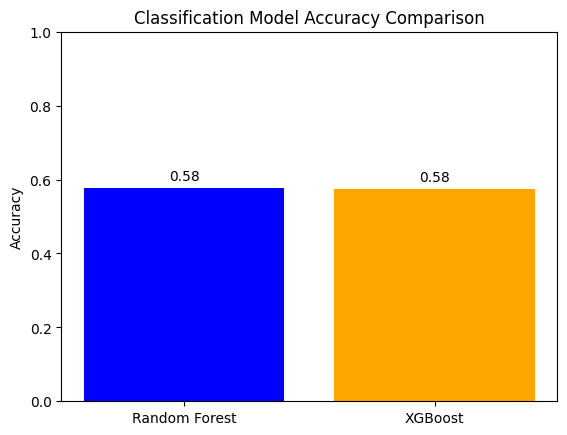

In [49]:
# Classification results visualization (full report)
models = ['Random Forest', 'XGBoost']
accuracies = [rf_clf_accuracy, xgb_clf_accuracy]
plt.bar(models, accuracies, color=['blue', 'orange'])
plt.ylabel('Accuracy')
plt.title('Classification Model Accuracy Comparison')
plt.ylim(0, 1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center')
plt.show()

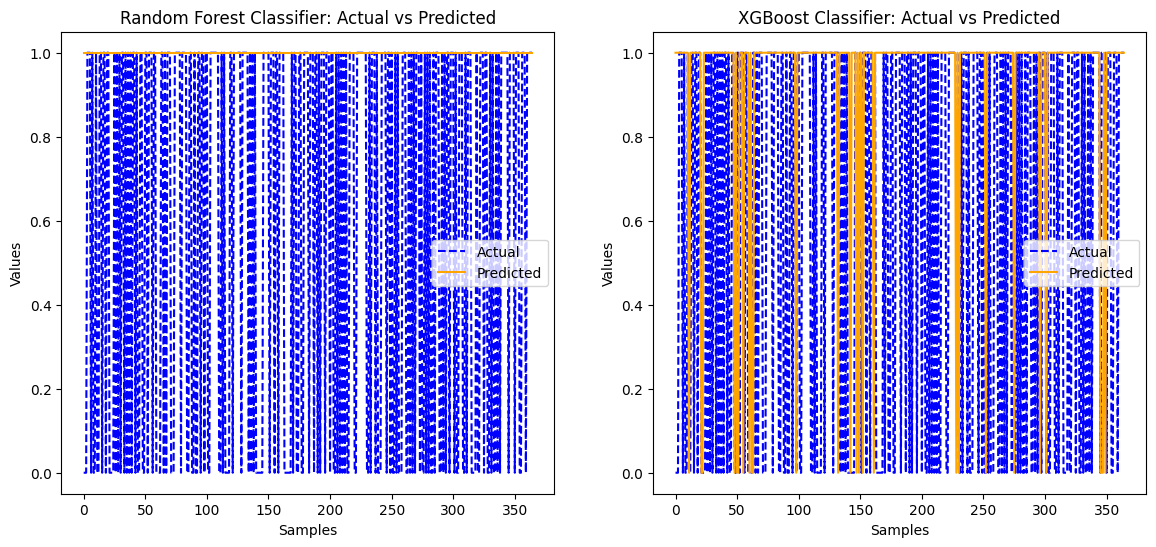

In [50]:
# Actual vs Predicted for Classification (line plot)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# random forest
ax1.plot(y_test_clf.values, label='Actual', color='blue', linestyle='--')
ax1.plot(y_pred_rf_clf, label='Predicted', color='orange')
ax1.set_title('Random Forest Classifier: Actual vs Predicted')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Values')
ax1.legend()

# xgboost
ax2.plot(y_test_clf.values, label='Actual', color='blue', linestyle='--')
ax2.plot(y_pred_xgb_clf, label='Predicted', color='orange')
ax2.set_title('XGBoost Classifier: Actual vs Predicted')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Values')
ax2.legend()

plt.show()

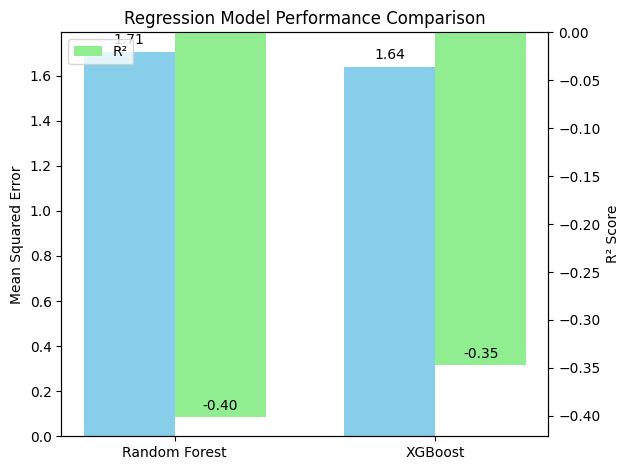

In [51]:
# Regression results visualization
models = ['Random Forest', 'XGBoost']
mses = [rf_reg_mse, xgb_reg_mse]
r2s = [rf_reg_r2, xgb_reg_r2] 
x = np.arange(len(models))
width = 0.35
fig, ax1 = plt.subplots()
bars1 = ax1.bar(x - width/2, mses, width, label='MSE', color='skyblue')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Regression Model Performance Comparison')
ax1.set_xticks(x)
ax1.set_xticklabels(models)
for bar in bars1:
    height = bar.get_height()
    ax1.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  
                 textcoords="offset points",
                 ha='center', va='bottom')
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, r2s, width, label='R²', color='lightgreen')
ax2.set_ylabel('R² Score')
for bar in bars2:
    height = bar.get_height()
    ax2.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),  
                 textcoords="offset points",
                 ha='center', va='bottom')
fig.tight_layout()

plt.legend(loc='upper left')
plt.show()

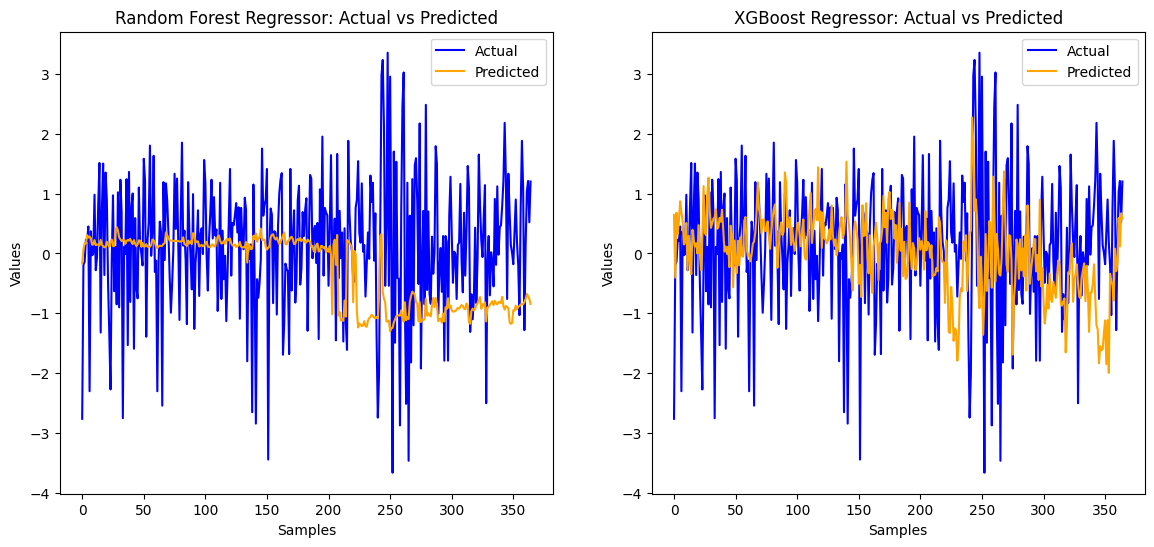

In [52]:
# Actual vs Predicted for Regression
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
# random forest
ax1.plot(y_test_reg.values, label='Actual', color='blue')
ax1.plot(y_pred_rf_reg, label='Predicted', color='orange')
ax1.set_title('Random Forest Regressor: Actual vs Predicted')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Values')
ax1.legend()

# xgboost
ax2.plot(y_test_reg.values, label='Actual', color='blue')
ax2.plot(y_pred_xgb_reg, label='Predicted', color='orange')
ax2.set_title('XGBoost Regressor: Actual vs Predicted')
ax2.set_xlabel('Samples')
ax2.set_ylabel('Values')
ax2.legend()

plt.show()

# Back Test

In [53]:
# define backtesting function
# classification backtest
def backtest_classification(model, data, predictor_vars):
    data = data.copy()
    data['Predicted_Direction'] = model.predict(scaler.transform(data[predictor_vars]))
    data['Strategy_Return'] = data['Price Change %'] * data['Predicted_Direction']
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return'] / 100).cumprod() - 1
    return data

# regression backtest
def backtest_regression(model, data, predictor_vars):
    data = data.copy()
    data['Predicted_Change'] = model.predict(scaler.transform(data[predictor_vars]))
    data['Predicted_Direction'] = (data['Predicted_Change'] > 0).astype(int)
    data['Strategy_Return'] = data['Price Change %'] * data['Predicted_Direction']
    data['Cumulative_Strategy_Return'] = (1 + data['Strategy_Return'] / 100).cumprod() - 1
    return data

# predict function
def predict_direction_and_change(model_clf, model_reg, latest_data, predictor_vars):
    latest_data_scaled = scaler.transform(latest_data[predictor_vars])
    predicted_direction = model_clf.predict(latest_data_scaled)[0]
    predicted_change = model_reg.predict(latest_data_scaled)[0]
    return predicted_direction, predicted_change